In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 100
learning_rate = 0.001
num_epochs = 10
l1_lambda = 0.005

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

/home/mattjac/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/mattjac/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


# regularization functions

In [60]:
import torch

# TODO: ChatGPT literally made this function up from the paper,
#       it is not in the original code
# Entropy regularization (ent_reg): This method encourages the activation probabilities of neurons to be uniform. A high entropy means that the neurons are uniformly active across the input examples, leading to less specialization of individual neurons. By maximizing the entropy of the activation probabilities, the neurons are encouraged to become more diverse and learn different aspects of the data, promoting disentanglement.
def ent_reg(h, epsilon=1e-8):
    p = torch.mean(h, dim=0)
    return -torch.sum(p * torch.log(p + epsilon))

# Activity (variance) maximization constraint from the code and paper.
def act_reg(h):
    return torch.mean(torch.sum(0.5 * h**2, axis=1), axis=0)

# Non-negativity regularization (nonneg_reg): This method encourages the activation values of neurons to be non-negative by penalizing negative activations. Non-negative activations can be more interpretable because they indicate the presence or absence of certain features in the input data. By enforcing non-negativity, the neurons are encouraged to learn distinct and sparse features, which helps in disentangling the learned representations.
def nonneg_reg(h):
    return torch.mean(torch.sum(torch.relu(-h)))

# TODO: ChatGPT literally made this function up from the paper,
#       it is not in the original code
# Sparsity regularization (sparse_reg): This method encourages the average activation of neurons to be sparse, meaning that only a few neurons are active at a time. It measures the difference between the desired sparsity level (rho) and the actual average activation (rho_hat) of neurons. By enforcing sparsity, the model learns to activate only a small number of neurons for a given input, which helps in finding disentangled representations where each neuron corresponds to a specific feature.
def sparse_reg(h, rho=0.1, epsilon=1e-8):
    rho_hat = torch.mean(h, dim=0) + epsilon
    return torch.sum(rho * torch.log(rho / rho_hat) + (1 - rho) * torch.log((1 - rho) / (1 - rho_hat)))

In [61]:
# Neural Network Model
class DisentangledNet(nn.Module):
    def __init__(self):
        super(DisentangledNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        h = torch.relu(self.fc1(x))
        self.hidden_activations = h  # Store hidden activations
        x = torch.relu(self.fc2(h))
        return x, h

# Train and test functions
def train(model, loader, criterion, optimizer, device, disentangle_ai, disentangle_human, alpha=0.1, beta=0.001, gamma=0.1):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs, hidden = model(images)
        loss = criterion(outputs, labels)

        if disentangle_ai:
            ent_reg_loss = ent_reg(hidden)
            nonneg_reg_loss = nonneg_reg(hidden)
            sparse_reg_loss = sparse_reg(hidden)
            loss += alpha * ent_reg_loss + beta * nonneg_reg_loss + gamma * sparse_reg_loss
        
        if disentangle_human:
            act_reg_loss = act_reg(hidden)
            nonneg_reg_loss = nonneg_reg(hidden)
            loss += alpha * act_reg_loss + beta * nonneg_reg_loss

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(loader)


def test(model, dataloader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs, hidden = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Training and testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
models = {
    'without_disentanglement': DisentangledNet().to(device),
    'with_disentanglement_ai': DisentangledNet().to(device),
    'with_disentanglement_human': DisentangledNet().to(device)}

for key, model in models.items():
    print(f"Training model {key}")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    disentangle_ai = key == 'with_disentanglement_ai'
    disentangle_human = key == 'with_disentanglement_human'

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device, disentangle_ai, disentangle_human)
        accuracy = test(model, test_loader, device)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}")

    torch.save(model.state_dict(), f"{key}_model.pth")

Training model without_disentanglement
Epoch [1/10], Loss: 1.1331, Accuracy: 0.6548
Epoch [2/10], Loss: 0.9301, Accuracy: 0.6622
Epoch [3/10], Loss: 0.8880, Accuracy: 0.6673
Epoch [4/10], Loss: 0.8608, Accuracy: 0.6726
Epoch [5/10], Loss: 0.8423, Accuracy: 0.6740
Epoch [6/10], Loss: 0.8278, Accuracy: 0.6746
Epoch [7/10], Loss: 0.8154, Accuracy: 0.6782
Epoch [8/10], Loss: 0.8060, Accuracy: 0.6791
Epoch [9/10], Loss: 0.7977, Accuracy: 0.6793
Epoch [10/10], Loss: 0.7916, Accuracy: 0.6775
Training model with_disentanglement_ai
Epoch [1/10], Loss: 2.0649, Accuracy: 0.9126
Epoch [2/10], Loss: 1.2986, Accuracy: 0.9359
Epoch [3/10], Loss: 1.1038, Accuracy: 0.9463
Epoch [4/10], Loss: 0.9992, Accuracy: 0.9503
Epoch [5/10], Loss: 0.9302, Accuracy: 0.9510
Epoch [6/10], Loss: 0.8807, Accuracy: 0.9519
Epoch [7/10], Loss: 0.8417, Accuracy: 0.9494
Epoch [8/10], Loss: 0.8124, Accuracy: 0.9534
Epoch [9/10], Loss: 0.7865, Accuracy: 0.9509
Epoch [10/10], Loss: 0.7683, Accuracy: 0.9497
Training model with_

==== Without disentanglement ====


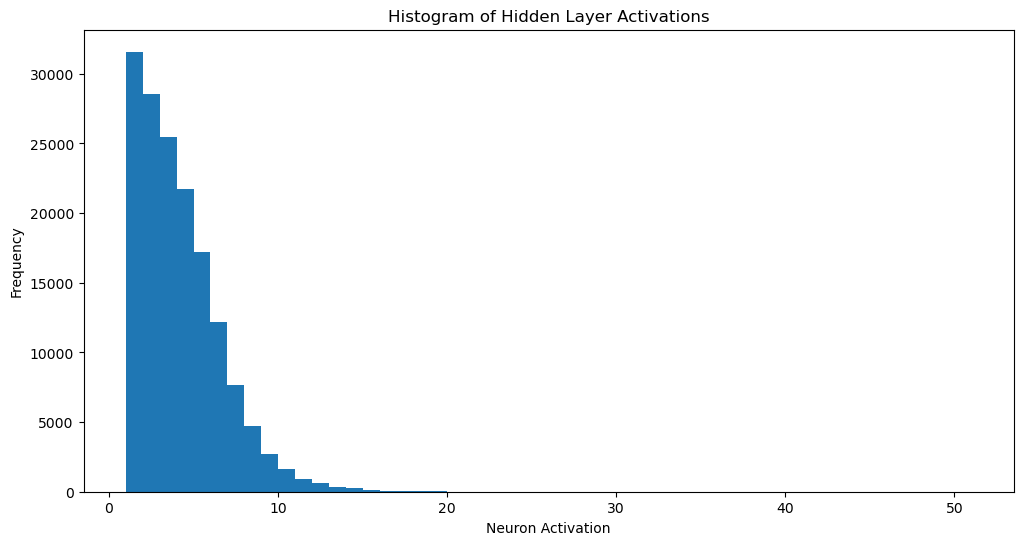

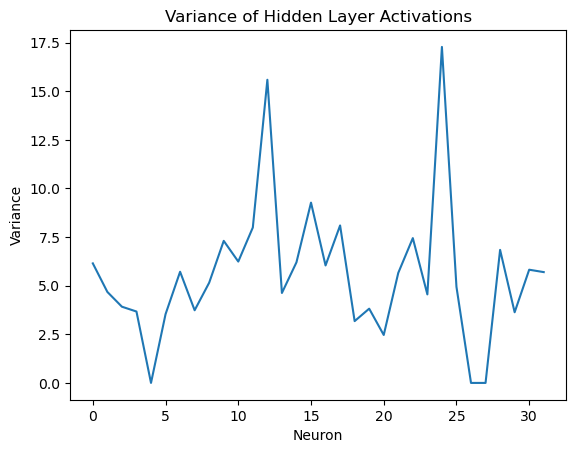

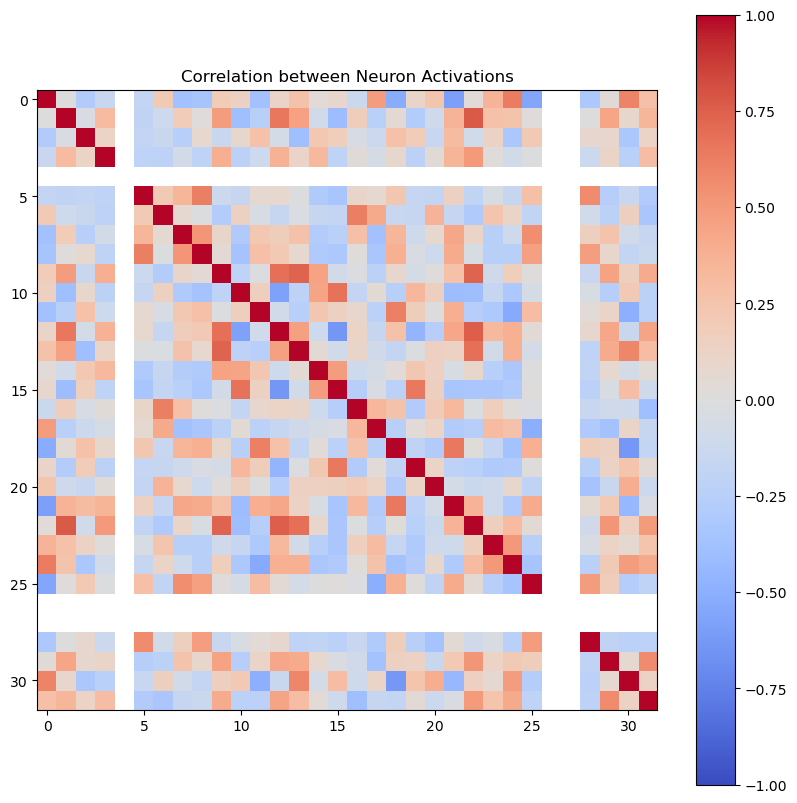

==== With disentanglement (AI) ====


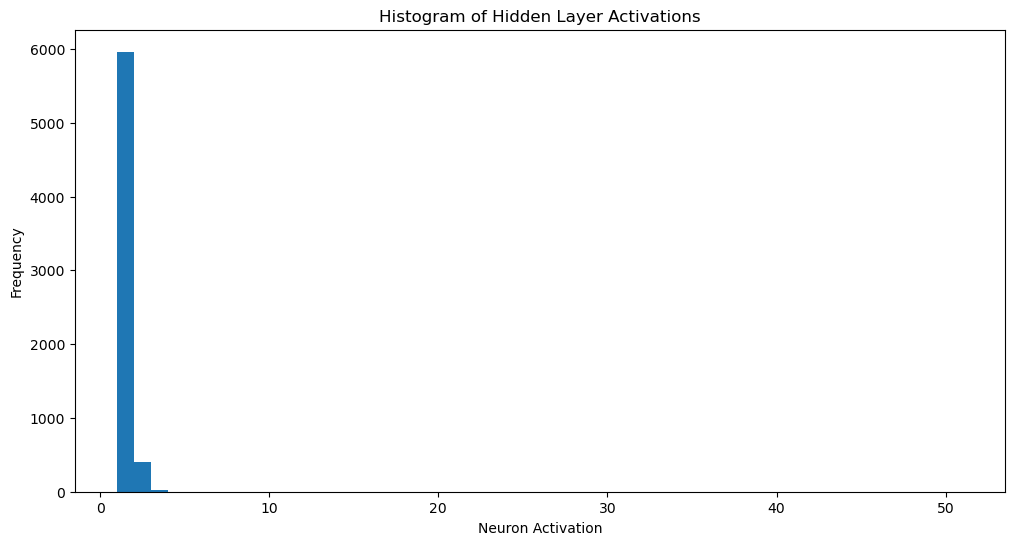

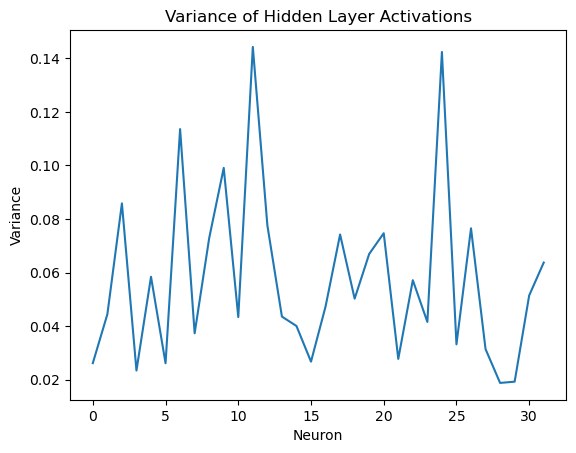

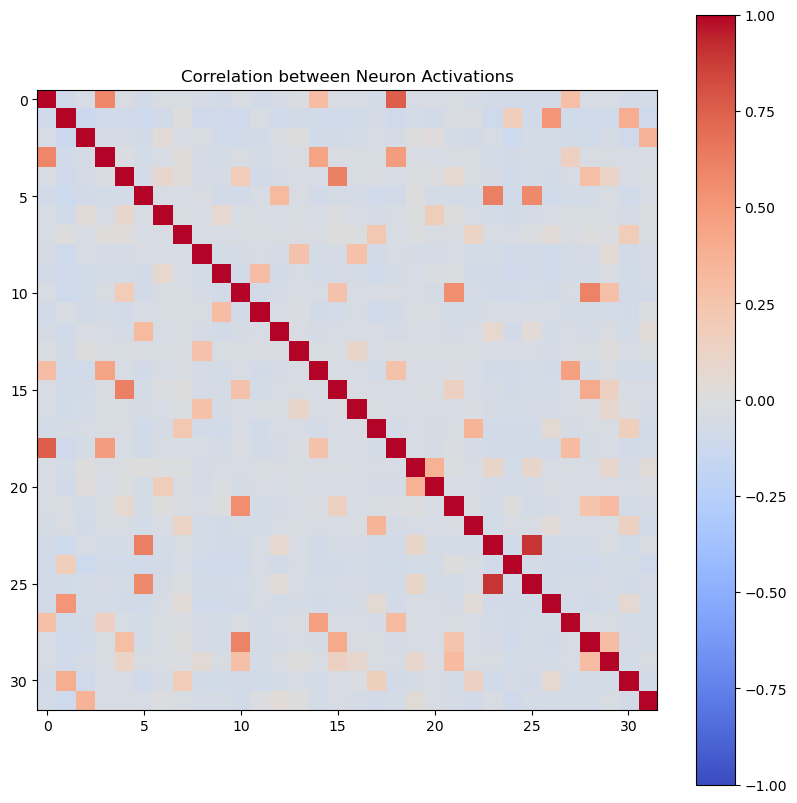

==== With disentanglement (human) ====


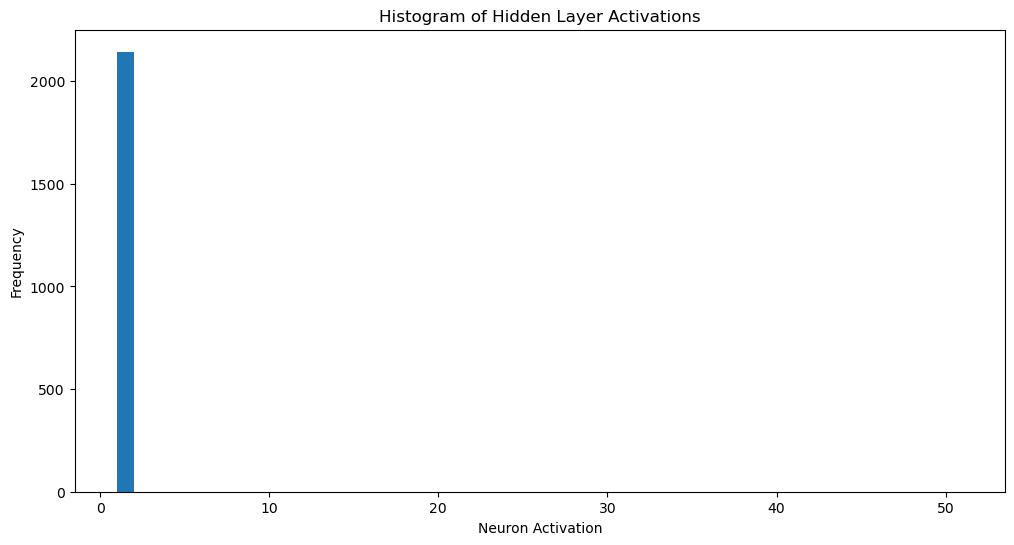

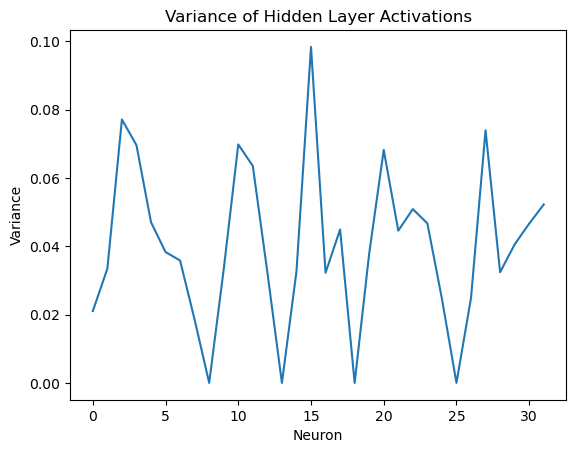

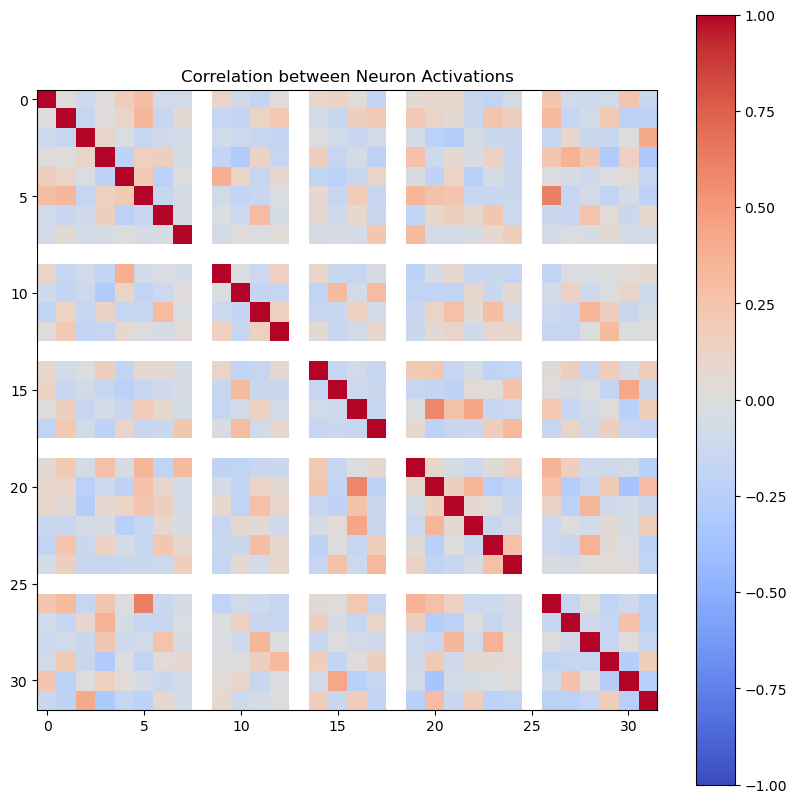

In [62]:
# Analyze the hidden representations
import numpy as np
import matplotlib.pyplot as plt

def analyze_activations(model, dataloader):
    all_hidden_activations = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.view(-1, 28*28).to(device)
            _ = model(images)
            hidden_activations = model.hidden_activations.cpu().numpy()
            all_hidden_activations.extend(hidden_activations)

    all_hidden_activations = np.array(all_hidden_activations)

    # Plot histogram of activations
    plt.figure(figsize=(12, 6))
    # remove the first bin, which is the just a garbage subunit
    plt.hist(all_hidden_activations.flatten(), bins=50, range=(1, 51))
    plt.xlabel('Neuron Activation')
    plt.ylabel('Frequency')
    plt.title('Histogram of Hidden Layer Activations')
    plt.show()

    # Compute activation variance
    activation_variances = np.var(all_hidden_activations, axis=0)
    plt.plot(activation_variances)
    plt.xlabel('Neuron')
    plt.ylabel('Variance')
    plt.title('Variance of Hidden Layer Activations')

    # Analyze correlation between neurons
    activation_correlation = np.corrcoef(all_hidden_activations, rowvar=False)
    plt.figure(figsize=(10, 10))
    plt.imshow(activation_correlation, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title('Correlation between Neuron Activations')
    plt.show()

model_without_disentanglement = models["without_disentanglement"]
model_with_disentanglement_ai = models["with_disentanglement_ai"]
model_with_disentanglement_human = models["with_disentanglement_human"]

# Analyze activations
print("==== Without disentanglement ====")
analyze_activations(model_without_disentanglement, test_loader)
print("==== With disentanglement (AI) ====")
analyze_activations(model_with_disentanglement_ai, test_loader)
print("==== With disentanglement (human) ====")
analyze_activations(model_with_disentanglement_human, test_loader)

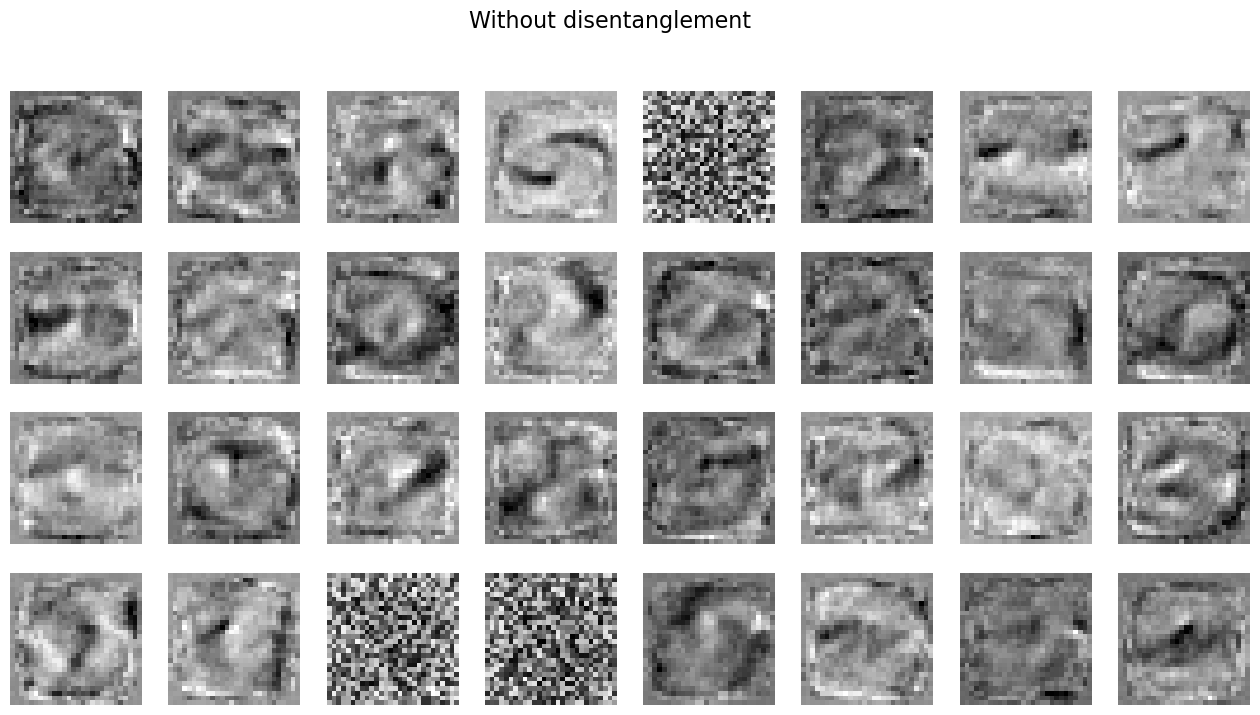

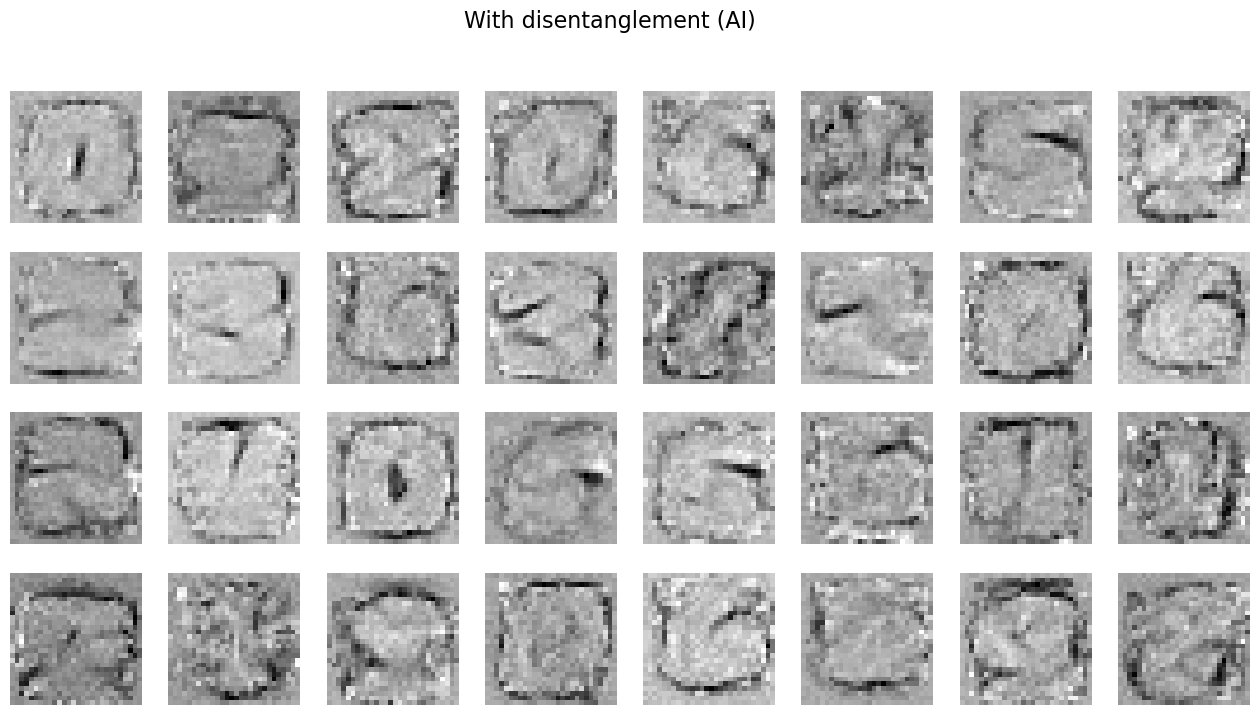

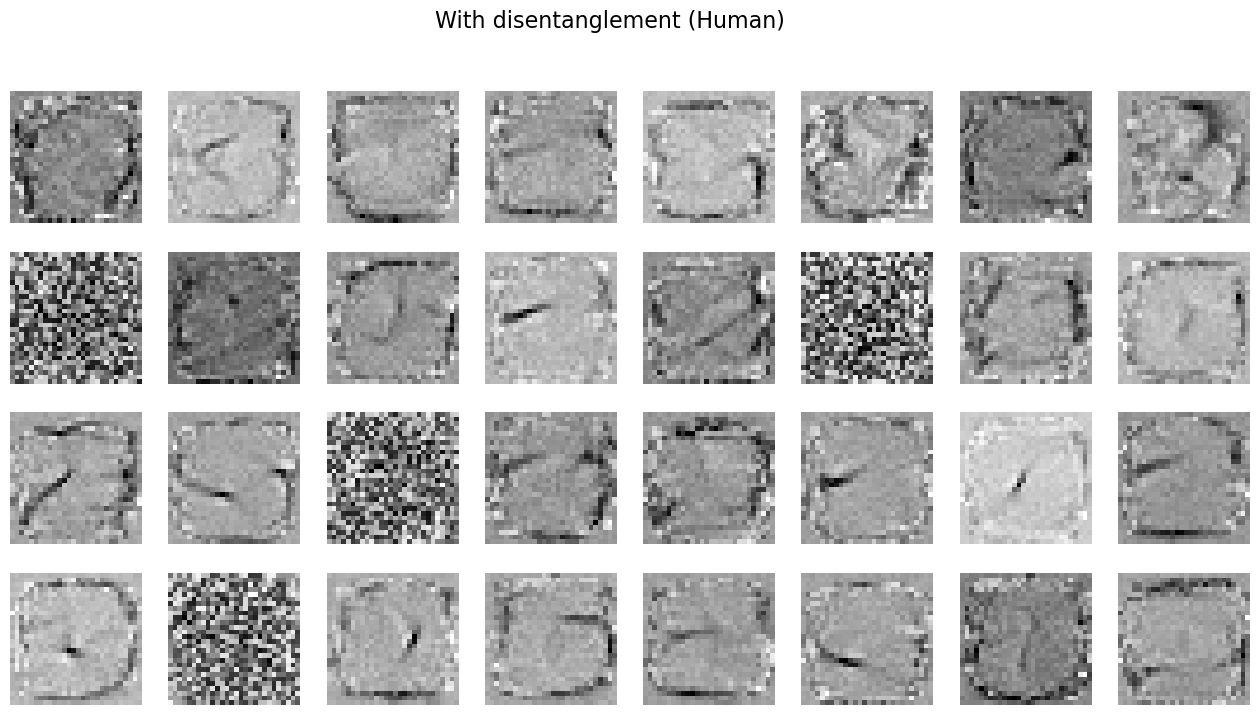

In [63]:
# Compare weights
model_without_disentanglement = models["without_disentanglement"]
model_with_disentanglement_ai = models["with_disentanglement_ai"]
model_with_disentanglement_human = models["with_disentanglement_human"]

# plot the weights in an 8 x 4 grid
fig, axs = plt.subplots(4, 8, figsize=(16, 8))
for i in range(4):
    for j in range(8):
        axs[i, j].imshow(model_without_disentanglement.fc1.weight.data[i * 8 + j].view(28, 28).cpu().numpy(), cmap='gray')
        axs[i, j].axis('off')

# plot the title
fig.suptitle('Without disentanglement', fontsize=16)

# plot the weights in an 8 x 4 grid
fig, axs = plt.subplots(4, 8, figsize=(16, 8))
for i in range(4):
    for j in range(8):
        axs[i, j].imshow(model_with_disentanglement_ai.fc1.weight.data[i * 8 + j].view(28, 28).cpu().numpy(), cmap='gray')
        axs[i, j].axis('off')
# plot the title
fig.suptitle('With disentanglement (AI)', fontsize=16)

# plot the weights in an 8 x 4 grid
fig, axs = plt.subplots(4, 8, figsize=(16, 8))
for i in range(4):
    for j in range(8):
        axs[i, j].imshow(model_with_disentanglement_human.fc1.weight.data[i * 8 + j].view(28, 28).cpu().numpy(), cmap='gray')
        axs[i, j].axis('off')
# plot the title
fig.suptitle('With disentanglement (Human)', fontsize=16)

plt.show()

# correlation between hidden units

In [25]:
# Measure activation variance: Compute the variance of the activations for each neuron across the dataset. In a disentangled representation, you would expect the variance to be more uniform across neurons, as they should all contribute equally to encoding the input data.


In [26]:
# Measure activation variance
def activation_variance(model, dataloader, device):
    model.eval()
    activations = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            _, hidden = model(images)
            activations.append(hidden)
    activations = torch.cat(activations, dim=0)
    return torch.var(activations, dim=0)

In [27]:
# Measure activation variance
var_without_disentanglement = activation_variance(model_without_disentanglement, test_loader, device)
var_with_disentanglement = activation_variance(model_with_disentanglement, test_loader, device)

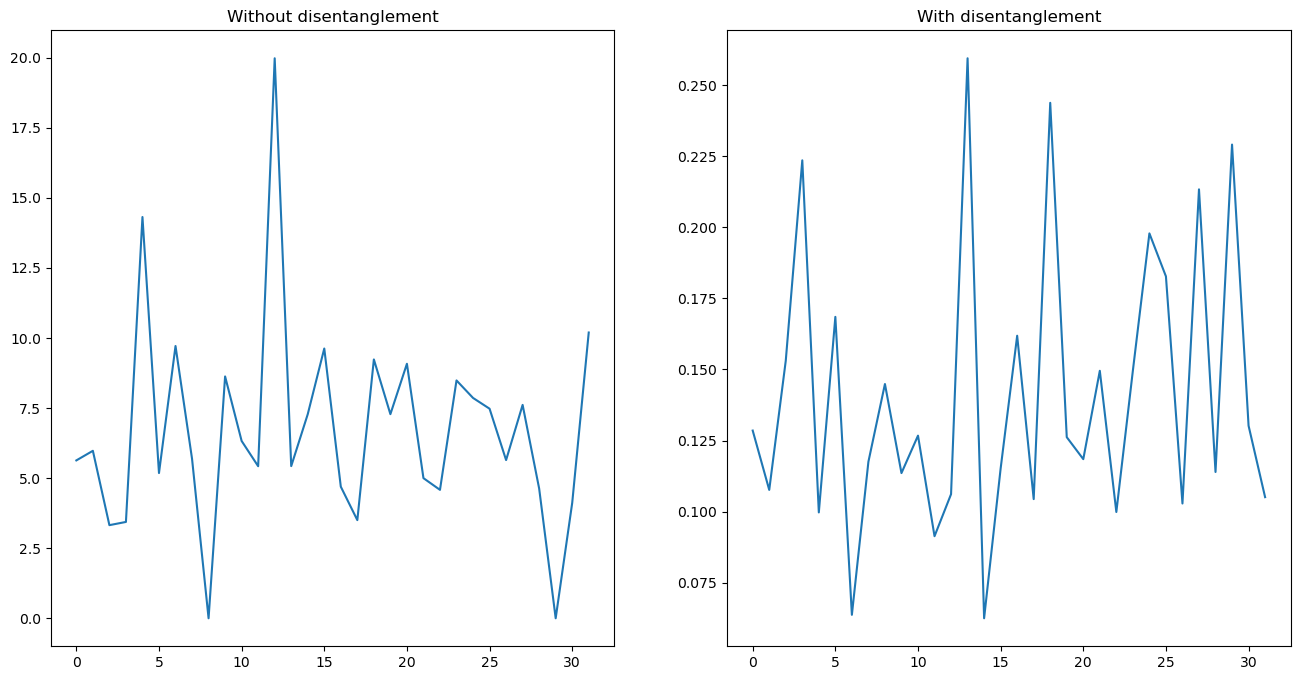

In [28]:
# Plot activation variance
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].plot(var_without_disentanglement.cpu().numpy())
axs[0].set_title("Without disentanglement")
axs[1].plot(var_with_disentanglement.cpu().numpy())
axs[1].set_title("With disentanglement")
plt.show()

In [29]:
# Inspect the activations: Examine the activations of the neurons in the hidden layer for a given input or a set of inputs. You can visualize them as histograms or heatmaps to analyze their distribution. For disentangled representations, you would expect a sparse activation pattern, with only a few neurons being active at a time.

In [30]:
# Inspect the activations
def inspect_activations(model, dataloader, device):
    model.eval()
    activations = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            _, hidden = model(images)
            activations.append(hidden)
    activations = torch.cat(activations, dim=0)
    return activations

In [33]:
# make the test loader
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

In [36]:
# Inspect the activations
activations_without_disentanglement = inspect_activations(model_without_disentanglement, test_loader, device)
activations_with_disentanglement = inspect_activations(model_with_disentanglement, test_loader, device)

# print the number of active neurons for each image
print(f"Without disentanglement: {torch.sum(activations_without_disentanglement > 0, dim=1)}")
print(f"With disentanglement: {torch.sum(activations_with_disentanglement > 0, dim=1)}")

Without disentanglement: tensor([27, 19, 23,  ..., 23, 19, 16], device='cuda:0')
With disentanglement: tensor([1, 7, 5,  ..., 7, 5, 3], device='cuda:0')


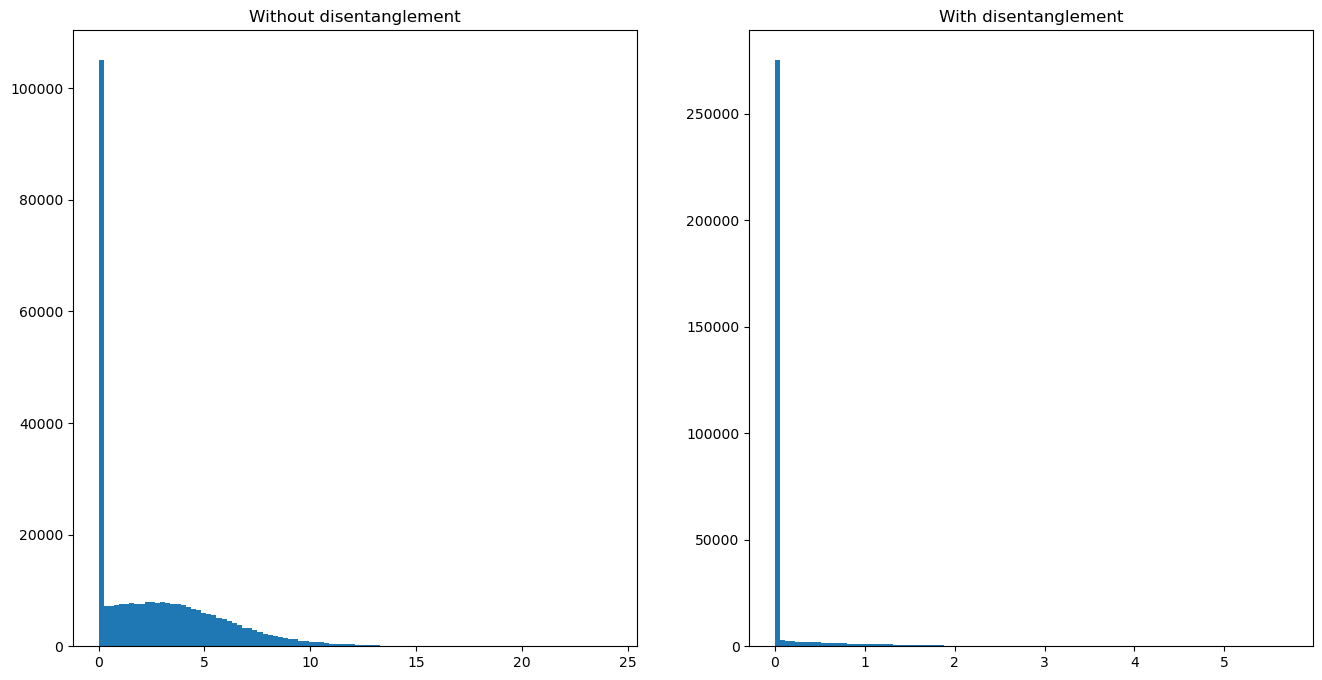

In [39]:
# plot histogram of activations
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].hist(activations_without_disentanglement.cpu().numpy().flatten(), bins=100)
axs[0].set_title("Without disentanglement")
axs[1].hist(activations_with_disentanglement.cpu().numpy().flatten(), bins=100)
axs[1].set_title("With disentanglement")
plt.show()